# <span style='background :yellow' > MIDAS INTERNSHIP TASK 2 ( Part 3 ) #2</span>

#### By: Yashika Khurana

### The aim here is to use network trained in part 1 to find test accuracy on MNIST dataset

### Importing libraries

In [130]:
from PIL import Image
import cv2
import os
from PIL import ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import keras

### The provided training data does not have labels. Nor can they be produced by programming (as done in Part 2 of the Task 2) because the images are randomly present across folders. They are in no specific order. 

### So, I am using a previously trained network to generate predictions on these images which I will use as labels for training them further.

### Checking if the pretrained model has loaded successfully

In [131]:
from keras.models import load_model

In [132]:
model=load_model("midas_model.h5")

### Created a dictionary corresponding to the labels as encoded

In [53]:
dictionary={
    "001":"0",
    "002":"1",
    "003":"2",
    "004":"3",
    "005":"4",
    "006":"5",
    "007":"6",
    "008":"7",
    "009":"8",
    "010":"9",
    "011":"A",
    "012":"B",
    "013":"C",
    "014":"D",
    "015":"E",
    "016":"F",
    "017":"G",
    "018":"H",
    "019":"I",
    "020":"J",
    "021":"K",
    "022":"L",
    "023":"M",
    "024":"N",
    "025":"O",
    "026":"P",
    "027":"Q",
    "028":"R",
    "029":"S",
    "030":"T",
    "031":"U",
    "032":"V",
    "033":"W",
    "034":"X",
    "035":"Y",
    "036":"Z",
    "037":"a",
    "038":"b",
    "039":"c",
    "040":"d",
    "041":"e",
    "042":"f",
    "043":"g",
    "044":"h",
    "045":"i",
    "046":"j",
    "047":"k",
    "048":"l",
    "049":"m",
    "050":"n",
    "051":"o",
    "052":"p",
    "053":"q",
    "054":"r",
    "055":"s",
    "056":"t",
    "057":"u",
    "058":"v",
    "059":"w",
    "060":"x",
    "061":"y",
    "062":"z"   
}

### Generating predictions for using them as labels

In [64]:
data=[]
labels=[]

for i in os.listdir("mnistTask"):
    if str(i)==".DS_Store": # DS_Store file gets created automatically, if-condition helps ignore it
        pass
    else:
    
        for j in os.listdir("mnistTask/"+str(i)):
    
            link="mnistTask/"+str(i)+"/"+str(j)
        
            img=cv2.imread(link)
            img=img[:,:,1]
            data.append(img)
            img=img.reshape((1,28,28,1))
            p=model.predict(img)
            pre=p.argmax()
            if pre in range(0,10):
                ans=dictionary['0'+'0'+ str(pre)]
            else:
                ans=dictionary['0'+ str(pre)]
            labels.append(ans)
                                                                    

In [66]:
len(data)

60000

In [67]:
len(labels)

60000

In [68]:
data=np.array(data)

In [69]:
labels=np.array(labels)

In [71]:
data.shape

(60000, 28, 28)

In [72]:
labels.shape

(60000,)

### Creating reverse dictionary to send numeric labels to the model

In [82]:
rev = {value : key for (key, value) in dictionary.items()}

In [80]:
data=data.reshape(len(data),28,28,1)

In [153]:
labels

array(['m', '3', 'c', ..., 'O', '2', 'H'], dtype='<U1')

In [83]:
new_labels=[]
for l in labels:
    new_labels.append(rev[l])
    

In [154]:
new_labels

array([49,  4, 39, ..., 25,  3, 18], dtype=uint8)

In [85]:
len(new_labels)

60000

In [86]:
new_labels=np.array(new_labels)

In [87]:
new_labels=new_labels.astype("uint8")

### Building the model using Keras Tuner for hyperparameter tuning

In [73]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),

    keras.layers.MaxPooling2D(pool_size=(2, 2)),  #1
    keras.layers.Dropout(rate=0.2),  #2
      
    
    keras.layers.Flatten(), #3
    keras.layers.Dense( #4
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(63, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [75]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

### Searching for the best model

In [77]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=3,directory='output',project_name="yashikakMidas")

In [88]:
tuner_search.search(data,new_labels,epochs=3,validation_split=0.1)

Trial 4 Complete [00h 07m 12s]
val_accuracy: 0.6518333554267883

Best val_accuracy So Far: 0.6518333554267883
Total elapsed time: 00h 30m 54s
INFO:tensorflow:Oracle triggered exit


### Selecting the best model

In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

### Training the model

In [90]:
model.fit(data, new_labels, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
1688/1688 [==============================] - 249s 147ms/step - loss: 1.0486 - accuracy: 0.6572 - val_loss: 0.8842 - val_accuracy: 0.7030
Epoch 5/10
1688/1688 [==============================] - 267s 158ms/step - loss: 0.9090 - accuracy: 0.6905 - val_loss: 0.8812 - val_accuracy: 0.6965
Epoch 6/10
1688/1688 [==============================] - 277s 164ms/step - loss: 0.8525 - accuracy: 0.7084 - val_loss: 0.8828 - val_accuracy: 0.6998
Epoch 7/10
1688/1688 [==============================] - 282s 167ms/step - loss: 0.7974 - accuracy: 0.7253 - val_loss: 0.8929 - val_accuracy: 0.6995
Epoch 8/10
1688/1688 [==============================] - 269s 160ms/step - loss: 0.7491 - accuracy: 0.7412 - val_loss: 0.8571 - val_accuracy: 0.7140
Epoch 9/10
1688/1688 [==============================] - 263s 156ms/step - loss: 0.7130 - accuracy: 0.7529 - val_loss: 0.9039 - val_accuracy: 0.6940
Epoch 10/10
1688/1688 [==============================] - 261s 154ms/step - loss: 0.6768 - accuracy: 0.7654 - val

### Importing MNIST test data.

In [91]:
df=pd.read_csv("mnist_test.csv")

In [92]:
df.head(n=10)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Segregating the testing data into input columns and their corresponding labels

In [93]:
full=df.values

In [94]:
x=full[:, 1:]
y=full[:,0]

In [95]:
x.shape

(10000, 784)

In [96]:
y.shape

(10000,)

In [97]:
x=x.reshape(len(x),28,28,1)

In [98]:
x.shape

(10000, 28, 28, 1)

### Finding accuracy on MNIST test set

In [141]:
res=model.predict(x)

In [142]:
res.shape

(10000, 63)

In [143]:
pred=[]
for i in res:
    pred.append(i.argmax())

In [144]:
len(pred)

10000

In [145]:
pred

[61,
 36,
 46,
 25,
 53,
 46,
 10,
 5,
 39,
 56,
 25,
 25,
 5,
 25,
 19,
 29,
 53,
 61,
 41,
 5,
 56,
 7,
 53,
 7,
 5,
 37,
 49,
 5,
 25,
 53,
 4,
 2,
 4,
 59,
 8,
 4,
 49,
 2,
 3,
 48,
 48,
 35,
 5,
 42,
 4,
 6,
 44,
 40,
 53,
 5,
 7,
 62,
 7,
 6,
 37,
 25,
 33,
 46,
 5,
 56,
 61,
 55,
 17,
 4,
 62,
 5,
 37,
 33,
 62,
 37,
 49,
 13,
 36,
 52,
 19,
 32,
 4,
 56,
 52,
 58,
 50,
 17,
 4,
 50,
 56,
 5,
 35,
 62,
 17,
 46,
 4,
 17,
 42,
 4,
 47,
 5,
 30,
 5,
 13,
 5,
 27,
 25,
 29,
 33,
 5,
 5,
 8,
 46,
 50,
 5,
 43,
 61,
 4,
 5,
 8,
 5,
 5,
 33,
 5,
 27,
 29,
 5,
 61,
 17,
 49,
 50,
 3,
 45,
 55,
 7,
 17,
 7,
 29,
 8,
 34,
 48,
 25,
 55,
 17,
 5,
 7,
 49,
 14,
 48,
 35,
 2,
 56,
 27,
 13,
 37,
 5,
 5,
 5,
 29,
 2,
 29,
 17,
 25,
 4,
 5,
 5,
 39,
 29,
 33,
 53,
 29,
 5,
 42,
 48,
 5,
 5,
 61,
 36,
 62,
 3,
 8,
 48,
 52,
 2,
 55,
 42,
 9,
 39,
 25,
 9,
 17,
 62,
 6,
 25,
 48,
 60,
 60,
 39,
 10,
 25,
 42,
 19,
 7,
 5,
 3,
 62,
 37,
 46,
 2,
 46,
 4,
 5,
 29,
 4,
 5,
 33,
 56,
 5,
 8,
 50,
 

### Finding mapping by using dictionary

In [160]:
results=[]
for i in range(len(pred)):
    if pred[i] in range(0,10):
        p=dictionary[str('0'+'0'+str(pred[i]))]
    else:
        p=dictionary[str('0'+str(pred[i]))]
    results.append(p)
    
        

In [178]:
y[10]

0

In [161]:
results

['y',
 'Z',
 'j',
 'O',
 'q',
 'j',
 '9',
 '4',
 'c',
 't',
 'O',
 'O',
 '4',
 'O',
 'I',
 'S',
 'q',
 'y',
 'e',
 '4',
 't',
 '6',
 'q',
 '6',
 '4',
 'a',
 'm',
 '4',
 'O',
 'q',
 '3',
 '1',
 '3',
 'w',
 '7',
 '3',
 'm',
 '1',
 '2',
 'l',
 'l',
 'Y',
 '4',
 'f',
 '3',
 '5',
 'h',
 'd',
 'q',
 '4',
 '6',
 'z',
 '6',
 '5',
 'a',
 'O',
 'W',
 'j',
 '4',
 't',
 'y',
 's',
 'G',
 '3',
 'z',
 '4',
 'a',
 'W',
 'z',
 'a',
 'm',
 'C',
 'Z',
 'p',
 'I',
 'V',
 '3',
 't',
 'p',
 'v',
 'n',
 'G',
 '3',
 'n',
 't',
 '4',
 'Y',
 'z',
 'G',
 'j',
 '3',
 'G',
 'f',
 '3',
 'k',
 '4',
 'T',
 '4',
 'C',
 '4',
 'Q',
 'O',
 'S',
 'W',
 '4',
 '4',
 '7',
 'j',
 'n',
 '4',
 'g',
 'y',
 '3',
 '4',
 '7',
 '4',
 '4',
 'W',
 '4',
 'Q',
 'S',
 '4',
 'y',
 'G',
 'm',
 'n',
 '2',
 'i',
 's',
 '6',
 'G',
 '6',
 'S',
 '7',
 'X',
 'l',
 'O',
 's',
 'G',
 '4',
 '6',
 'm',
 'D',
 'l',
 'Y',
 '1',
 't',
 'Q',
 'C',
 'a',
 '4',
 '4',
 '4',
 'S',
 '1',
 'S',
 'G',
 'O',
 '3',
 '4',
 '4',
 'c',
 'S',
 'W',
 'q',
 'S',
 '4'

In [162]:
len(results)

10000

In [164]:
y

array([7, 2, 1, ..., 4, 5, 6])

In [163]:
len(y)

10000

### Finding accuracy

In [165]:
count=0
for i in range(len(results)):
    if results[i]==y[i]:
        count=count+1
acc=(count/len(results))*100
print(acc)

0.0


### Qualitative analysis example

In [166]:
x[6].shape

(28, 28, 1)

In [167]:
a=x[6].reshape((28,28))

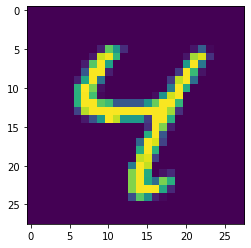

In [168]:
plt.imshow(a)

In [179]:
y[6]

4

In [181]:
results[6]

'9'

### Here, 4 has been recognized as 9. 

### Mainly, network used in Part 1 consisted of both numbers and letters. So, numbers have been mis-attributed to letters.